tgb - 2022/01/14 - PC experiments for AMS Annual:

1. Circle constant latitude: lat-by-lat vs concatenated, pcstable vs correlations vs SHAP, brute-force vs climate-invariant  
2. Repeat for circle of constant longitude    

# Imports

In [53]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from cbrain.climate_invariant import *

import matplotlib as mpl
import numpy as np

import pickle

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

import shap
shap.initjs()

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/tigramite/independence_tests/gpdc.py:16: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/tigramite/independence_tests/cmiknn.py:15: UserWarning: cannot import name 'tigramite_cython_code'
  warnings.warn(str(e))


From Brei and Nando

In [23]:
def select_links(tau_min, tau_max, parents, children):
    """
    This function selects the causal links that will be tested by
    PCMCI. The links are selected such that per each variable in
    `children` all `parents` are stablished as causes, and no other
    causal relationships exist.
    
    Assumes `parents` and `children` are disjoint sets, and that all
    variables are included in the union of both sets.
    
    Parameters
    ----------
    tau_min : int
        Minimum time lag to test. Note that zero-lags are undirected.
    tau_max : int
        Maximum time lag. Must be larger or equal to tau_min.
    parents : set of int
        List of variables that will be assigned as a parent link.
        Assumed to be disjoint with children
    children : set of int
        List of variables that will be assigned a link from a parent.
        Assumed to be disjoint with parents
    Returns
    -------
    selected_links: dict
        Dictionary of selected links for Tigramite
        
    """

    parents = set(parents)
    children = set(children)

    selected_links = dict()
    # Set the default as all combinations of the selected variables
    for var in [*children, *parents]:
        if var in children:
            # Children can be caused only by parents and by themselves
            selected_links[var] = [
                (parent, -lag)
                for parent in parents
                for lag in range(tau_min, tau_max + 1)
            ]
        else:
            selected_links[var] = []

    return selected_links

Coordinates

In [158]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'
path_folder = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/'
pathAQ_0K = path_folder + 'fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.00'
coor = xr.open_dataset(pathAQ_0K+'00-03-01-00000.nc')

Plotting parameters

In [25]:
fz = 15 # Here we define the fontsize 
lw = 2 # the linewidth
siz = 75 # and the scattered dots' size

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

# Prepare data

## Reorganize raw dataset to make it a time serie

In [2]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'

In [3]:
path_train = path_data + '2022_01_10_TRAIN_For_Nando_t-dt.nc' 
path_valid = path_data + '2022_01_10_VALID_For_Nando_t-dt.nc'
path_norm = path_data + '2022_01_10_Norm_Outputs_t-dt.nc'

In [4]:
train_data_raw = xr.open_dataset(path_train)

In [41]:
raw_var_name = train_data_raw['var_names'].values

In [18]:
Nlat = 64
Nlon = 128
NT = int(train_data_raw['vars'].shape[0]/(Nlat*Nlon))
Ninp0 = 94 # without tendencies at t-dt
Noup = 65
Ninp = Ninp0+Noup
Nvars = Ninp+Noup

In [6]:
raw_vars = train_data_raw['vars'].values

In [17]:
raw_vars = np.reshape(raw_vars,(NT,Nlat,Nlon,Nvars))

In [39]:
raw_vars_time = DT*np.arange(0,NT)/(24*3600)

In [117]:
N_toexclude = 2 # Exclude upper atmospheric PHQ as inputs because zero

In [118]:
input0_idx = np.arange(0,Ninp0)
inputs_idx = np.concatenate((input0_idx,np.arange(Ninp0+Noup+N_toexclude,Nvars)))
output_idx = np.arange(Ninp0+N_toexclude,Ninp0+Noup)

In [104]:
iNST = 59
NST = np.mean(raw_vars[:,:,:,iNST],axis=0)

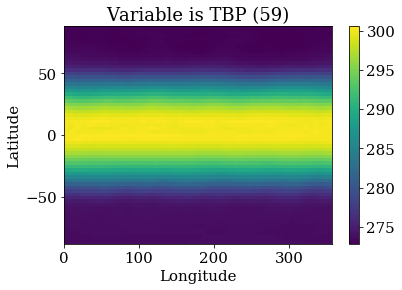

In [26]:
plt.pcolormesh(coor.lon,coor.lat,NST)
plt.colorbar()
plt.title('Variable is '+(train_data_raw['var_names'].values)[iNST]+' ('+str(iNST)+')');
plt.xlabel('Longitude');
plt.ylabel('Latitude');

## Reorganize climate-invariant dataset to make it a time serie

# Circle of constant latitude

In [105]:
lat_test = 0
lon_test = 150

In [106]:
ilon = np.argmin(np.abs(lon_test-coor.lon.values))
ilat = np.argmin(np.abs(lat_test-coor.lat.values))

In [107]:
tau_min = 1
tau_max = 1
children = [Ninp-N_toexclude]
parents = np.arange(0,Ninp-N_toexclude)

In [108]:
sel_links = select_links(tau_min, tau_max, parents, children)

In [109]:
parcorr = ParCorr(significance='analytic')

## Brute-force mapping

### Without concatenating

In [129]:
par_raw_lat0 = {}
nlink = {}

In [135]:
for ilon in np.arange(0,128):
    par_raw_lat0[ilon] = {}
    nlink[ilon] = {}
    for ioup in np.arange(0,Noup-N_toexclude):
        ioup0 = Ninp0+N_toexclude+ioup
        print('ilon=',ilon,'and ioup=',ioup0,'          ',end='\r')
        raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
        raw_vars_oup = raw_vars[:-1,ilat,ilon,[ioup0]]
        raw_vars_combined = np.concatenate((raw_vars_inp,
                                            raw_vars_oup),axis=-1)
        raw_vars_nam = np.concatenate((raw_var_name[inputs_idx],
                                       [raw_var_name[ioup0]]))
        raw_vars_frame = pp.DataFrame(raw_vars_combined,datatime=raw_vars_time,
                                      var_names=raw_vars_nam)
        pcmci = PCMCI(dataframe=raw_vars_frame,cond_ind_test=parcorr,verbosity=0);
        tmp = pcmci.run_pc_stable(selected_links = sel_links,
                                  tau_min = 1,tau_max=1,pc_alpha=0.01)
        par_raw_lat0[ilon][ioup0] = tmp[Ninp-N_toexclude]
        nlink[ilon][ioup0] = len(par_raw_lat0[ilon][ioup0])

Intersection of all parents

In [ ]:
par_raw_lat0_intersect = {}
nlink_intersect = {}

In [196]:
for ioup in np.arange(0,Noup-N_toexclude):
    ioup0 = Ninp0+N_toexclude+ioup
    print('ioup=',ioup0,'          ',end='\r')
    par_raw_lat0_intersect[ioup0] = {}
    for iinp in range(Ninp-N_toexclude):
        par_raw_lat0_intersect[ioup0][iinp] = 0
        for ilon in range(128):
            tmp = np.sum([(i[0]==iinp) for i in par_raw_lat0[ilon][ioup0]])
            par_raw_lat0_intersect[ioup0][iinp] = \
            (ilon*par_raw_lat0_intersect[ioup0][iinp]+tmp)/(ilon+1)
            
    nlink_intersect[ioup0] = \
    np.sum([par_raw_lat0_intersect[ioup0][i] for i \
            in par_raw_lat0_intersect[ioup0]])/(Ninp-N_toexclude)

### With concatenating

In [141]:
par_raw_lat0_concat = {}
nlink_concat = {}

In [156]:
for ioup in np.arange(0,Noup-N_toexclude):
    ioup0 = Ninp0+N_toexclude+ioup
    raw_vars_nam = np.concatenate((raw_var_name[inputs_idx],
                                   [raw_var_name[ioup0]]))
    
    # Initialize time series
    ilon = 0
    raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
    raw_vars_oup = raw_vars[:-1,ilat,ilon,[ioup0]]
    raw_vars_combined = np.concatenate((raw_vars_inp,
                                        raw_vars_oup),axis=-1)
    
    # Concatenate lon in the time direction to form a long time series
    for ilon in range(127):
        print('ioup=',ioup0,'& ilon=',ilon,'             ',end='\r')
        raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
        raw_vars_oup = raw_vars[:-1,ilat,ilon,[ioup0]]
        tmp = np.concatenate((raw_vars_inp,raw_vars_oup),axis=-1)
        raw_vars_combined = np.concatenate((raw_vars_combined,tmp),
                                           axis=0)
    
    raw_vars_frame = pp.DataFrame(raw_vars_combined,datatime=raw_vars_time,
                                  var_names=raw_vars_nam)
    pcmci = PCMCI(dataframe=raw_vars_frame,cond_ind_test=parcorr,verbosity=0);
    tmp = pcmci.run_pc_stable(selected_links = sel_links,
                              tau_min = 1,tau_max=1,pc_alpha=0.01)
    par_raw_lat0_concat[ioup0] = tmp[Ninp-N_toexclude]
    nlink_concat[ioup0] = len(par_raw_lat0_concat[ioup0])

### With correlations (fully concatenated)

In [197]:
corr = {}

In [209]:
for ioup in np.arange(0,Noup-N_toexclude):
    ioup0 = Ninp0+N_toexclude+ioup
    
    raw_vars_nam = np.concatenate((raw_var_name[inputs_idx],
                                   [raw_var_name[ioup0]]))
    
    # Initialize time series
    ilon = 0
    raw_vars_inp = raw_vars[:,ilat,ilon,inputs_idx]
    raw_vars_oup = raw_vars[:,ilat,ilon,[ioup0]]
    raw_vars_combined = np.concatenate((raw_vars_inp,
                                        raw_vars_oup),axis=-1)
    
    # Concatenate lon in the time direction to form a long time series
    for ilon in range(127):
        print('ioup=',ioup0,'& ilon=',ilon,'             ',end='\r')
        raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
        raw_vars_oup = raw_vars[:-1,ilat,ilon,[ioup0]]
        tmp = np.concatenate((raw_vars_inp,raw_vars_oup),axis=-1)
        raw_vars_combined = np.concatenate((raw_vars_combined,tmp),
                                           axis=0)
    
    corr[ioup] = np.zeros((Ninp-N_toexclude,))
    for iinp in range(Ninp-N_toexclude):
        corr[ioup][iinp] = np.corrcoef(x=raw_vars_combined[:,iinp],
                                       y=raw_vars_combined[:,Ninp-N_toexclude])[0,1]

### Using SHAP

Load NN model

In [ ]:
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'
save_name = '2022_01_14_Test_Nando_BF_t-dt'

In [ ]:
model_BF = tf.keras.models.load_model(path_HDF5+save_name)

### Save links

In [210]:
save_name = '2022_01_14_lat0_BF'
hf = open(pathPKL+save_name+'.pkl','wb')

In [211]:
F_data = {'par_raw_lat0':par_raw_lat0,
         'nlink':nlink,
         'par_raw_lat0_intersect':par_raw_lat0_intersect,
         'nlink_intersect':nlink_intersect,
         'corr':corr}

pickle.dump(F_data,hf)
hf.close()

## Visualizations for brute-force mapping

In [269]:
raw_vars_nam_inp = train_data_raw['var_names'][inputs_idx].values
for ivar in range(3):
    for ilev in range(30):
        raw_vars_nam_inp[30*ivar+ilev] = \
        raw_vars_nam_inp[30*ivar+ilev] + \
        '%2.0f'%(coor.lev[ilev].values)

for ilev in range(30-N_toexclude):
    raw_vars_nam_inp[Ninp0+ilev] = raw_vars_nam_inp[Ninp0+ilev] + '%2.0f'%(coor.lev[ilev+2].values)
for ilev in range(30):
    raw_vars_nam_inp[Ninp0+30-N_toexclude+ilev] = \
    raw_vars_nam_inp[Ninp0+30-N_toexclude+ilev] + \
    '%2.0f'%(coor.lev[ilev].values)

raw_vars_nam_oup = train_data_raw['var_names'][Ninp0+np.arange(0,Noup)].values
for ivar in range(2):
    for ilev in range(30):
        raw_vars_nam_oup[30*ivar+ilev] = \
        raw_vars_nam_oup[30*ivar+ilev] + \
        '%2.0f'%(coor.lev[ilev].values)
raw_vars_nam_oup = raw_vars_nam_oup[2:]

In [321]:
raw_vars_nam_inp

array(['QBP 4', 'QBP 8', 'QBP14', 'QBP25', 'QBP38', 'QBP55', 'QBP72',
       'QBP88', 'QBP103', 'QBP122', 'QBP143', 'QBP168', 'QBP198',
       'QBP233', 'QBP274', 'QBP322', 'QBP379', 'QBP446', 'QBP525',
       'QBP610', 'QBP691', 'QBP763', 'QBP821', 'QBP860', 'QBP887',
       'QBP913', 'QBP936', 'QBP957', 'QBP976', 'QBP993', 'TBP 4', 'TBP 8',
       'TBP14', 'TBP25', 'TBP38', 'TBP55', 'TBP72', 'TBP88', 'TBP103',
       'TBP122', 'TBP143', 'TBP168', 'TBP198', 'TBP233', 'TBP274',
       'TBP322', 'TBP379', 'TBP446', 'TBP525', 'TBP610', 'TBP691',
       'TBP763', 'TBP821', 'TBP860', 'TBP887', 'TBP913', 'TBP936',
       'TBP957', 'TBP976', 'TBP993', 'VBP 4', 'VBP 8', 'VBP14', 'VBP25',
       'VBP38', 'VBP55', 'VBP72', 'VBP88', 'VBP103', 'VBP122', 'VBP143',
       'VBP168', 'VBP198', 'VBP233', 'VBP274', 'VBP322', 'VBP379',
       'VBP446', 'VBP525', 'VBP610', 'VBP691', 'VBP763', 'VBP821',
       'VBP860', 'VBP887', 'VBP913', 'VBP936', 'VBP957', 'VBP976',
       'VBP993', 'PS', 'SOLIN', 'SHF

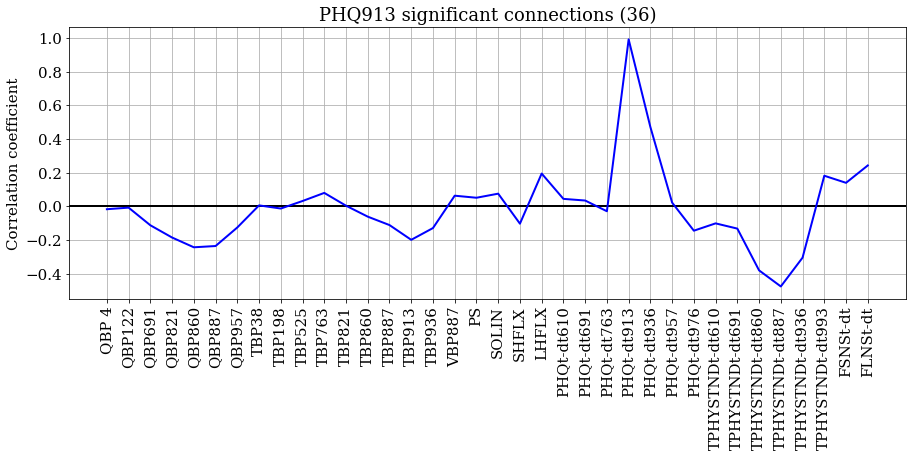

In [289]:
ioup = 23
ioup0 = Ninp0+N_toexclude+ioup

plt.figure(figsize=(15,5))
plt.axhline(y=0,color='k')
links = np.sort(np.array([i[0] for i in par_raw_lat0_concat[ioup0]]))
plt.plot(corr[ioup][links],color='b')
plt.xticks(np.arange(0,int(nlink_concat[ioup0])),
           raw_vars_nam_inp[links],
           rotation='vertical');
plt.title(raw_vars_nam_oup[ioup]+' significant connections ('+str(int(nlink_concat[ioup0]))+')')
plt.ylabel('Correlation coefficient')
plt.grid()

In [324]:
corr_array = np.zeros((Noup-N_toexclude,Ninp-N_toexclude))
link_array = np.zeros((Noup-N_toexclude,Ninp-N_toexclude))
link_latbylat = np.zeros((Noup-N_toexclude,Ninp-N_toexclude))
for ioup in range(Noup-N_toexclude):
    ioup0 = Ninp0+N_toexclude+ioup
    links = np.array([i[0] for i in par_raw_lat0_concat[ioup0]])
    corr_array[ioup,:] = corr[ioup]
    link_array[ioup,links] = 1
    for iinp in range(Ninp-N_toexclude):
        link_latbylat[ioup,iinp] = par_raw_lat0_intersect[ioup0][iinp]

Text(0.5, 0, 'Input index')

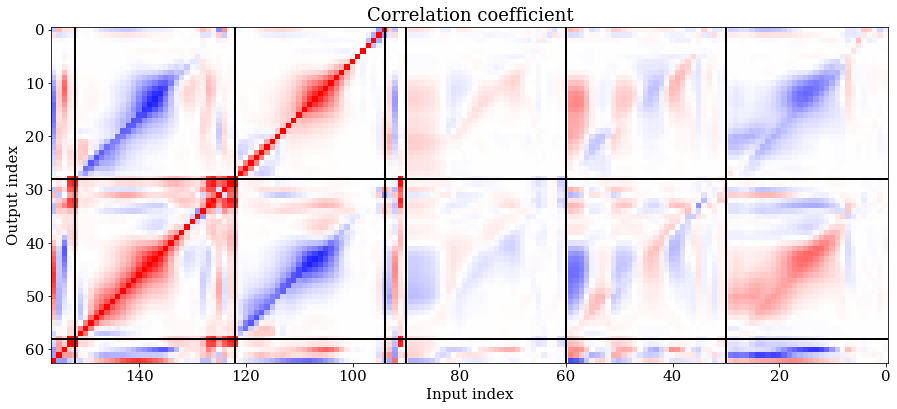

In [346]:
plt.figure(figsize=(15,15))
plt.imshow(corr_array,cmap='bwr',vmin=-1,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')
plt.gca().invert_xaxis()
plt.title('Correlation coefficient')
plt.ylabel('Output index')
plt.xlabel('Input index')

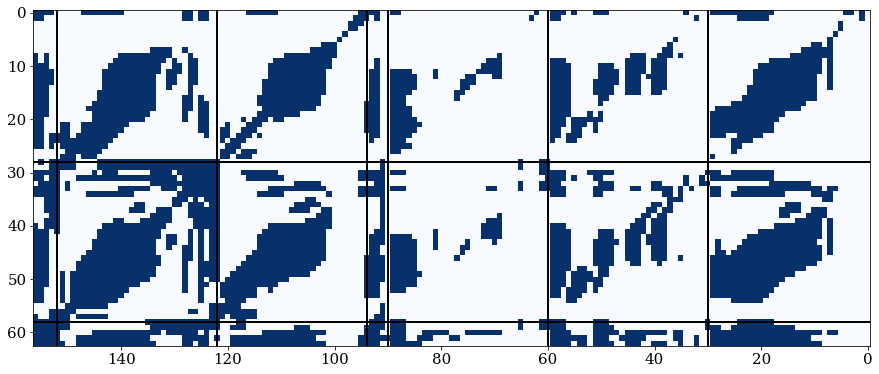

In [345]:
plt.figure(figsize=(15,15))
plt.imshow(np.abs(corr_array)>0.1,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')
plt.gca().invert_xaxis()

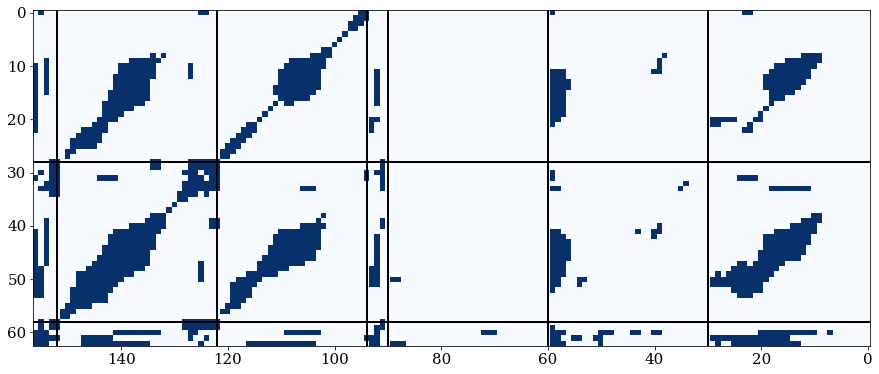

In [344]:
plt.figure(figsize=(15,15))
plt.imshow(np.abs(corr_array)>0.25,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')
plt.gca().invert_xaxis()

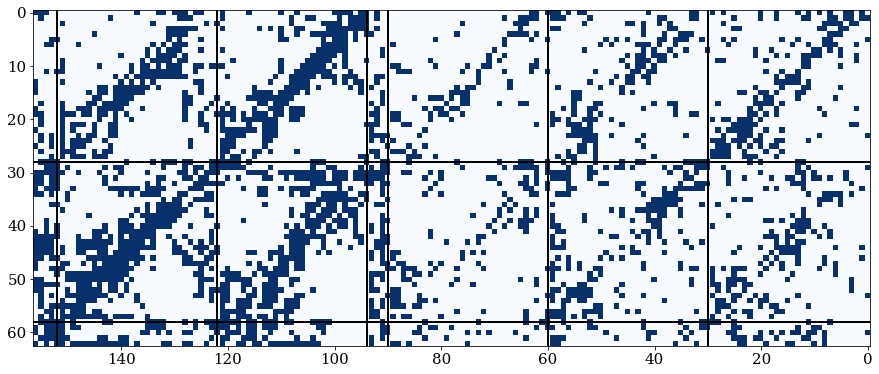

In [320]:
plt.figure(figsize=(15,15))
plt.imshow(link_array,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')

plt.gca().invert_xaxis()

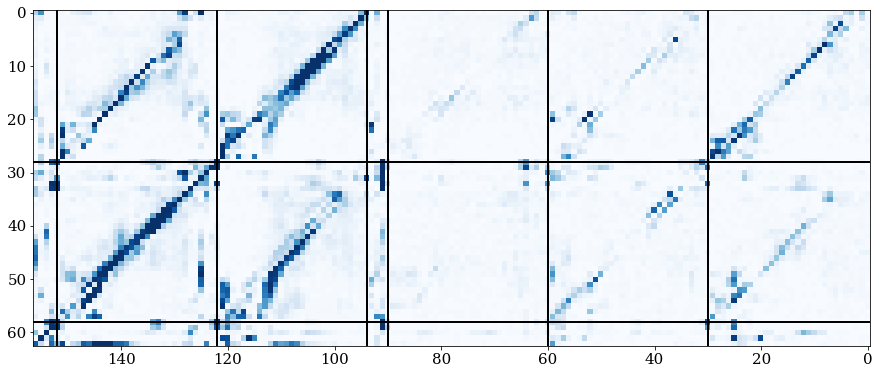

In [325]:
plt.figure(figsize=(15,15))
plt.imshow(link_latbylat,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')

plt.gca().invert_xaxis()

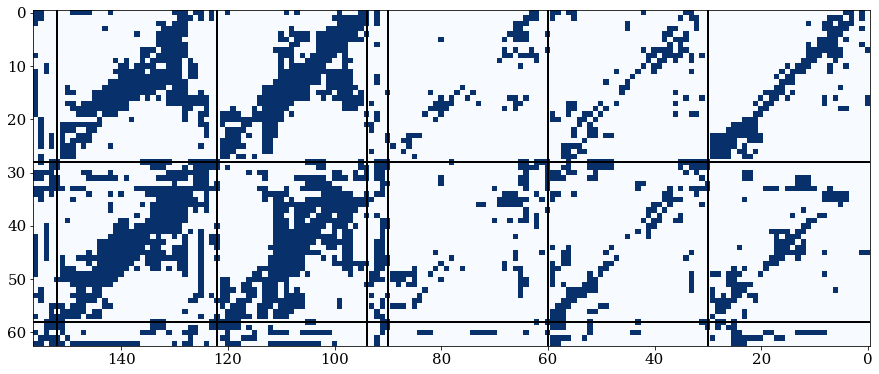

In [336]:
plt.figure(figsize=(15,15))
plt.imshow(link_latbylat>0.05,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')

plt.gca().invert_xaxis()

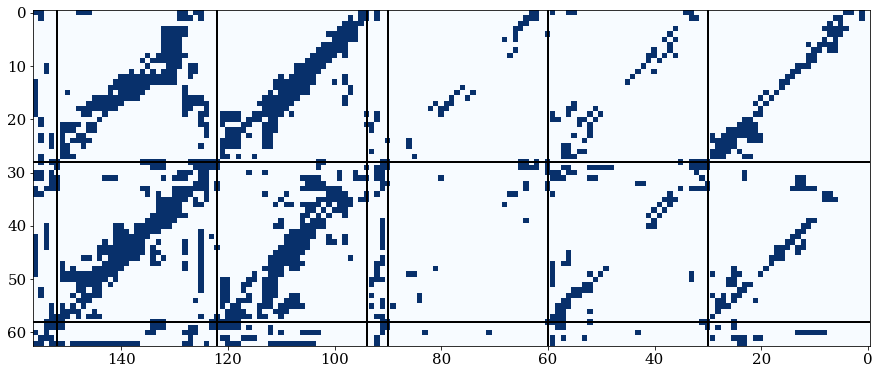

In [335]:
plt.figure(figsize=(15,15))
plt.imshow(link_latbylat>0.1,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')

plt.gca().invert_xaxis()

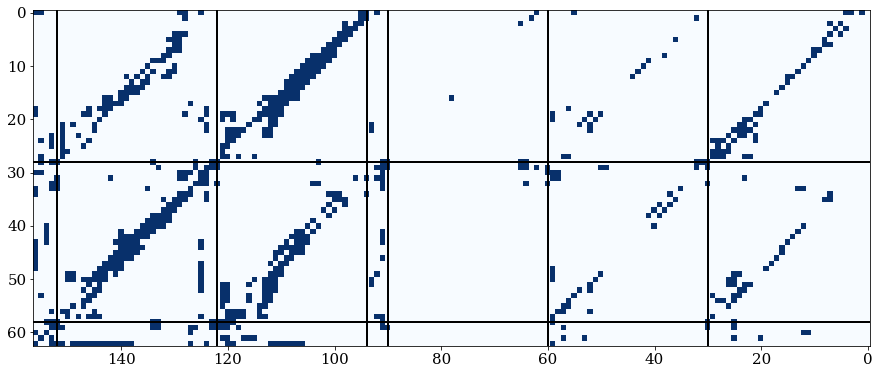

In [337]:
plt.figure(figsize=(15,15))
plt.imshow(link_latbylat>0.25,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')

plt.gca().invert_xaxis()

## Climate-invariant mapping

# Circle of constant longitude

## Brute-force mapping

## Climate-invariant mapping